In [1]:
import os
import sys

import numpy as np
from tqdm import tqdm

from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score, confusion_matrix

from matplotlib import pyplot as plt

from utils.datasets import load_dataset, normalize_data
from utils.protocols import get_model_scores, get_threshold, get_subset
from utils.scores import get_scores, get_auc_score, get_avpr_score


In [2]:
img_format = 'pdf'
dpi = 512

# Choose the dataset to analyse
dataset_name = "thyroid" #"arrhythmia" "thyroid", "kddcup"
fig_title = {
    "thyroid": "Thyroid",
    "arrhythmia": "Arrhythmia",
    "kddcup": "KDD Cup"
}

n_runs = 100
n_exp = 100

In [3]:
# Study the impact of number of anomaly in test set (for perfect ratio)
x, y = load_dataset(dataset_name)

if dataset_name == "kddcup":
    x, y = get_subset(x, y)

nb_anomaly = np.sum(y==1)
n_exp = min(n_exp, nb_anomaly)

f1_scores = np.zeros((n_exp, n_runs))
auc_scores = np.zeros((n_exp, n_runs))
avpr_scores = np.zeros((n_exp, n_runs))

nb_anomalies = np.linspace(1, nb_anomaly, num=n_exp, dtype=np.int)

for j in tqdm(range(n_runs)):
    x_run, y_run = x.copy(), y.copy()
    
    # Split into train test with a clean train set
    X_train, X_test, y_train, y_test = train_test_split(
        x_run[y_run==0], y_run[y_run==0], test_size=0.2)
    
    X_train, X_test, X_anomalous = normalize_data(
        fit_on=X_train, transform=(X_train, X_test, x_run[y_run==1]))

    # Fit a gaussian on the train set
    clf = OneClassSVM(gamma='auto', nu=0.9)
    clf.fit(X_train)
    
    s_normal = get_model_scores(clf, X_test)
    s_anomaly = get_model_scores(clf, X_anomalous)
            
    # Select X value of anomaly
    for i, na in enumerate(nb_anomalies):
    
        anomaly = np.random.choice(nb_anomaly, na, replace=False)       
        s_sub_anomaly = s_anomaly[anomaly]
    
        scores = np.concatenate((s_normal, s_sub_anomaly), axis=0)
        labels = np.concatenate((np.zeros(len(s_normal)),np.ones(len(s_sub_anomaly))), axis=0)
        
        # Get contamination rate estimation
        cont = np.sum(labels) / len(labels)
        
        # Compute threshold with test set
        thresh = get_threshold(scores, cont)

        # Compute different scores
        y_hat = (scores >= thresh).astype(int)
        
        # Get all scores
        _, _, f1_score = get_scores(labels, y_hat)
        auc_score = get_auc_score(labels, scores)
        avpr_score = get_avpr_score(labels, scores)
        
        f1_scores[i, j] = f1_score
        auc_scores[i, j] = auc_score
        avpr_scores[i, j] = avpr_score
        
f1_means = np.mean(f1_scores, axis=1)
f1_stds = np.std(f1_scores, axis=1)

auc_means = np.mean(auc_scores, axis=1)
auc_stds = np.std(auc_scores, axis=1)

avpr_means = np.mean(avpr_scores, axis=1)
avpr_stds = np.std(avpr_scores, axis=1)

# anomalies = range(0, nb_anomaly)
ratios = nb_anomalies / (nb_anomalies + len(y_test))

[DOWNLOAD] Download dataset thyroid from https://www.dropbox.com/s/bih0e15a0fukftb/thyroid.mat?dl=1


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


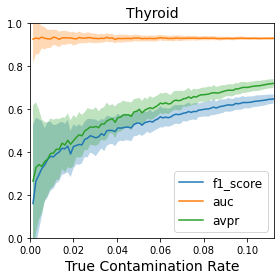

In [4]:
plt.figure(figsize=[4, 4])
plt.ylim([0.0, 1.0])
plt.xlim([0.0, np.max(ratios)])

plt.plot(ratios, f1_means, label='f1_score')
plt.fill_between(ratios, f1_means-f1_stds, f1_means+f1_stds, alpha=0.3)

plt.plot(ratios, auc_means, label='auc')
plt.fill_between(ratios, auc_means-auc_stds, auc_means+auc_stds, alpha=0.3)

plt.plot(ratios, avpr_means, label='avpr')
plt.fill_between(ratios, avpr_means-avpr_stds, avpr_means+avpr_stds, alpha=0.3)

plt.legend(loc='lower right', fontsize=12)
plt.xlabel(f"True Contamination Rate", fontsize=14)
plt.title(fig_title[dataset_name], fontsize=14)


plt.tight_layout()
plt.savefig(f"./results/impact_true_contamination_{dataset_name}."+img_format, format=img_format, dpi=dpi)
plt.show()